# Analyze OME-Zarr for illumination bias
Notebook to process OME-Zarr files generated by Fractal to measure illumination biases

If measurements were made per FOV (using the FOV_ROI_table), this notebook should just run. Otherwise, use a modulo calculation witht he image size to mape back the coordinates to coordinates in a FOV (if imaged in a grid)

path needs to be the path to a AnnData table in a given well

In [25]:
# pip install anndata
# pip install zarr
# pip install seaborn

In [1]:
import anndata as ad
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [10]:
#path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_with_illum_corr_v1/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
path = "/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/nicole_illumcorr-60x-1/AssayPlate_Greiner_#655090.zarr/E/04/0/tables/Channel1"
path = "/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/nicole_illumcorr-60x-1/AssayPlate_Greiner_#655090.zarr/E/04/0/tables/Channel2"
path = "/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/nicole_illumcorr-60x-1/AssayPlate_Greiner_#655090.zarr/E/04/0/tables/Channel3"
path = "/Volumes/tungsten/scratch/gliberal/Users/luetjoel/Fractal/illumination_correction/nicole_illumcorr-60x-1/AssayPlate_Greiner_#655090.zarr/E/04/0/tables/Channel4"
adata = ad.read_zarr(path)
df = adata.to_df()

/Users/joel/opt/miniconda3/envs/napari-ome-zarr/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Manually create histogram measurements

In [3]:
def calculate_mean_per_bin(df, feature = 'mean_intensity', nb_bins = 20, img_dims_x = 2560, img_dims_y = 2160):
    df_average_intensity = pd.DataFrame()

    start_y = 0
    for y in range(nb_bins):
        start_x = 0
        for x in range(nb_bins):
            window_x = int(img_dims_x / nb_bins)
            window_y = int(img_dims_y / nb_bins)
            mean_value = df[(df['centroid-2'] > start_x) & 
               (df['centroid-2'] < start_x + window_x) & 
               (df['centroid-1'] > start_y) & 
               (df['centroid-1'] < start_y + window_y)][feature].mean()
            new_entry = pd.DataFrame([[start_x + window_x/2, -(start_y + window_y/2), mean_value]], columns = ['X_center', 'Y_center', f'Mean_{feature}'])
            df_average_intensity = pd.concat([df_average_intensity, new_entry])
            start_x += window_x
        start_y += window_y

    return df_average_intensity

def plot_illum_corr(df_average_intensity):
    std_bins = df_average_intensity['Mean_mean_intensity'].std()

    ax = sns.scatterplot(
        data=df_average_intensity, 
        x='X_center', 
        y='Y_center', 
        hue='Mean_mean_intensity', 
        palette="viridis",
        s=150,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = ax.figure.suptitle(f"Standard Deviation: {std_bins:.2f}")

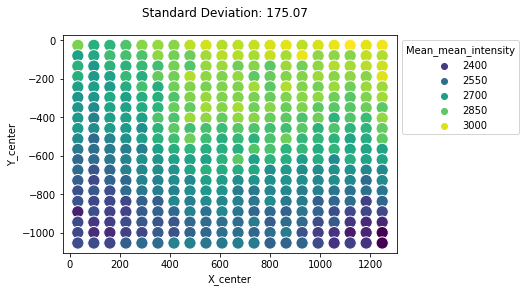

In [11]:
feature = 'mean_intensity'
df_average_intensity = calculate_mean_per_bin(df, feature, img_dims_x = 1280, img_dims_y = 1080)
plot_illum_corr(df_average_intensity)

In [162]:
path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_with_illum_corr_fullWell_FOV-v2_cellpose_highres/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
adata = ad.read_zarr(path)
df = adata.to_df()

/Users/joel/mambaforge/envs/fractal-metadata/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
df

,area,bbox_area,convex_area,equivalent_diameter,max_intensity,mean_intensity,min_intensity,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,standard_deviation_intensity
0,5440.0,9504.0,0.0,21.820604,4521.0,3208.907715,1771.0,0.0,48.500000,579.558838,0.0,0.0,536.0,1.0,108.0,624.0,0.0,48.080170,579.564758,384.686005
1,8848.0,17280.0,0.0,25.661507,4837.0,3285.342773,1864.0,0.0,66.823692,789.239624,0.0,0.0,720.0,1.0,120.0,864.0,0.0,65.837128,789.241455,422.574127
2,3392.0,5280.0,0.0,18.641710,4422.0,3164.996094,2145.0,0.0,24.801888,844.028320,0.0,0.0,808.0,1.0,60.0,896.0,0.0,24.100964,844.313965,337.026825
3,2560.0,3168.0,0.0,16.972551,4297.0,2989.541504,1706.0,0.0,20.400000,932.224976,0.0,0.0,896.0,1.0,44.0,968.0,0.0,20.582920,931.535950,408.799744
4,2080.0,2816.0,0.0,15.837559,3426.0,2566.252930,1251.0,0.0,42.946156,1023.930786,0.0,12.0,1000.0,1.0,76.0,1044.0,0.0,43.914886,1024.507690,332.599701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51320,1664.0,2288.0,0.0,14.702287,3715.0,2999.956787,2210.0,0.0,1059.538452,289.153839,0.0,1036.0,263.0,1.0,1080.0,315.0,0.0,1059.469360,288.937714,199.598663
51321,3536.0,4400.0,0.0,18.901859,4604.0,3054.299805,1572.0,0.0,1060.269287,695.812195,0.0,1036.0,651.0,1.0,1080.0,751.0,0.0,1061.035767,697.105652,462.885223
51322,1952.0,2736.0,0.0,15.505784,4028.0,3003.663330,2206.0,0.0,1065.270508,1167.188477,0.0,1044.0,1127.0,1.0,1080.0,1203.0,0.0,1065.262939,1167.654663,273.914185
51323,848.0,1056.0,0.0,11.743541,3877.0,2611.212158,1807.0,0.0,1068.820801,567.066040,0.0,1056.0,547.0,1.0,1080.0,591.0,0.0,1069.032959,567.188110,300.382935


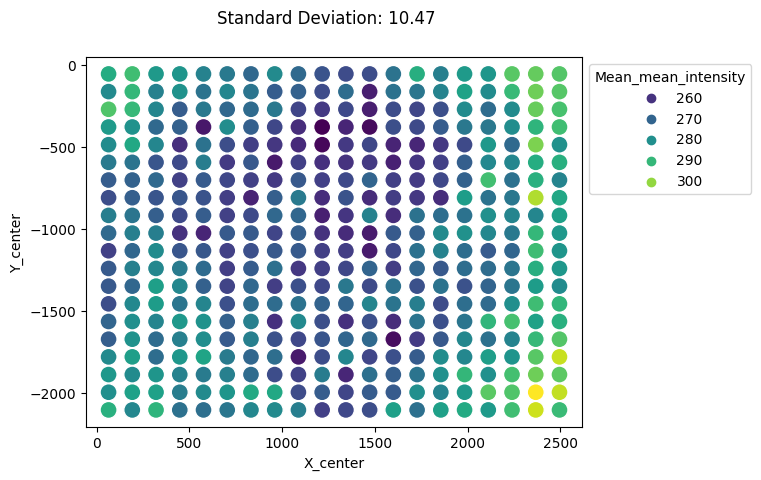

In [ ]:
feature = 'mean_intensity'
df_average_intensity = calculate_mean_per_bin(df, feature)
plot_illum_corr(df_average_intensity)